In [1]:
import sklearn #software machine learning library for the Python programming language.
from sklearn import model_selection 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,KFold, train_test_split
import numpy as np
import pandas as pd
import shap
from shap import waterfall_plot
import matplotlib.pyplot as plt

In [2]:
# load the csv file as a data frame
df = pd.read_csv('/Users/grace/Desktop/Courses/Master_thesis/Datsets/redwinequality.csv')

# Separate the target variable
X = df.drop('quality', axis=1)
y = df['quality']

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Initialize the Random Forest Classifier
cls = RandomForestClassifier(max_depth=10, random_state=42)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [18]:
# Evaluate performance on testing set
test_score = cls.score(X_test, y_test)
print("Testing set score:", test_score)

# Perform cross-validation to test the ability of a machine learning model to predict new data
cv_scores = cross_val_score(cls, df.drop("quality", axis=1),
                            df["quality"], cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Testing set score: 0.64375
Cross-validation scores: [0.55       0.528125   0.621875   0.575      0.60501567]
Mean cross-validation score: 0.5760031347962382


In [19]:
from sklearn.metrics import accuracy_score

# Make predictions on the training and test data
y_train_pred = cls.predict(X_train)
y_test_pred = cls.predict(X_test)
# print the train and test predictions
print(y_test_pred)
print(y_train_pred)

# Calculate the accuracy of the predictions
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
# Print the train and test accuracy
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

[5 5 5 5 6 5 5 5 6 6 7 5 6 5 5 6 5 6 7 5 5 6 5 6 5 6 6 5 5 6 5 6 6 6 5 5 6
 6 5 6 5 5 6 5 5 6 6 6 5 6 5 5 6 7 5 6 6 6 6 5 6 6 5 5 7 5 6 6 7 5 6 5 6 6
 6 5 7 5 6 7 5 7 5 6 6 6 5 6 7 5 6 5 5 5 5 5 5 6 5 5 5 5 6 7 6 7 6 5 6 5 7
 5 7 5 5 6 6 5 5 6 6 5 6 5 6 5 6 5 5 6 6 5 5 6 6 5 5 5 5 6 7 6 7 6 5 5 6 6
 6 5 6 6 5 5 6 5 6 6 5 6 6 6 6 5 5 6 6 5 5 5 5 5 7 5 7 6 6 5 5 5 5 6 5 6 5
 7 6 6 7 5 5 6 5 6 6 5 5 6 5 7 5 5 5 5 7 6 5 6 6 6 8 5 5 6 6 6 6 5 6 6 5 6
 6 6 6 5 5 7 5 5 5 5 7 6 5 7 5 6 6 5 5 5 6 7 5 7 6 6 6 5 6 6 5 6 6 5 5 6 6
 6 6 6 5 6 6 6 5 5 6 6 5 6 5 5 6 6 6 6 6 6 7 5 5 5 5 7 5 6 5 6 5 7 6 5 5 6
 5 6 6 6 5 5 6 6 6 5 6 6 6 7 5 5 6 5 6 6 5 5 6 5]
[6 6 6 ... 5 7 6]
Train accuracy: 0.946051602814699
Test accuracy: 0.64375


alcohol                 0.172200
sulphates               0.116912
total sulfur dioxide    0.109343
volatile acidity        0.097413
density                 0.093359
chlorides               0.075525
fixed acidity           0.073440
residual sugar          0.069864
pH                      0.067708
citric acid             0.064706
free sulfur dioxide     0.059529
dtype: float64


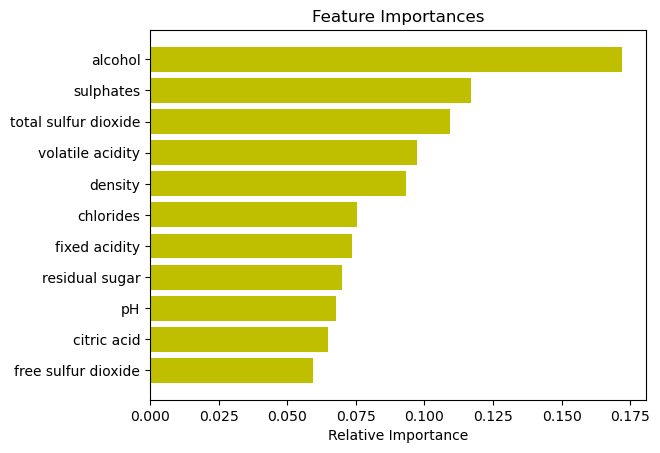

In [20]:
# get the most important features for the model which are the ones that have a strong correlation with the target variable
importances = pd.Series(cls.feature_importances_, index=X_train.columns)
# Print feature importance
print(importances.sort_values(ascending=False))

#plot the importances
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance') #The relative importance is calculated as the decrease in impurity or Gini index caused by splitting on that feature, normalized across all features.
plt.show()

In [21]:
#SelectFromModel: Meta-transformer for selecting features based on importance weights.
from sklearn.feature_selection import SelectFromModel

# Select the top 10 features
sfm = SelectFromModel(cls, threshold=-np.inf, max_features=10) #-np.inf is used as the threshold value, which means no feature will be removed based on importance score. 
sfm.fit(X_train, y_train)

# Transform the training and test data to contain only the top 10 features
X_train_top = sfm.transform(X_train)
X_test_top = sfm.transform(X_test)

# Initialize the Random Forest Classifier with the same parameters as before
cls_top = RandomForestClassifier(max_depth=5, random_state=42)

# Train the model on the training data with only the top 10 features
cls_top.fit(X_train_top, y_train)

# Make predictions on the training and test data
y_train_top_pred = cls_top.predict(X_train_top)
y_test_top_pred = cls_top.predict(X_test_top)

# Calculate the accuracy of the predictions
train_top_accuracy = accuracy_score(y_train, y_train_top_pred)
test_top_accuracy = accuracy_score(y_test, y_test_top_pred)

# Print the train and test accuracy with the top 10 features
print('Train accuracy with top 10 features:', train_top_accuracy)
print('Test accuracy with top 10 features:', test_top_accuracy)


Train accuracy with top 10 features: 0.7013291634089132
Test accuracy with top 10 features: 0.590625


In [23]:
# Hyperparameter Tuning: Use the validation set to tune the model's hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [2, 4, 5, 6, 8, 10],
    'n_estimators': [10, 50, 100, 150, 200]
}
# Create a Random Forest Classifier object
rfc = RandomForestClassifier(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
# Train the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 200}


In [24]:
# Evaluate the performance of the model on the validation set
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
accuracy = grid_search.score(X_val, y_val)
print(f'Validation accuracy: {accuracy:.4f}')

Validation accuracy: 0.9707


Explanation part using SHAP

Positive SHAP value means positive impact on prediction, leading the model to predict 1. Negative SHAP value means negative impact, leading the model to predict 0.

[array([[-1.33043373e-03,  1.15931085e-03,  7.13800724e-05, ...,
         8.51559790e-04,  2.73273274e-03, -1.29746904e-03],
       [-8.35151388e-04,  4.61291692e-03,  1.39373280e-03, ...,
        -1.82037014e-03, -3.70600525e-03, -2.69136549e-04],
       [-1.30028402e-03,  7.60658019e-04,  2.22681533e-04, ...,
         2.66353725e-05, -2.60086550e-03,  1.52830617e-04],
       ...,
       [-1.17507600e-03, -1.61448254e-03, -6.73284018e-04, ...,
         1.05030441e-03, -1.49444474e-03, -8.58916891e-04],
       [-1.63631986e-03, -8.55211006e-05, -7.95909260e-04, ...,
         1.03037415e-03, -2.59236672e-03,  1.10912088e-03],
       [-1.04265996e-03, -2.53751320e-03, -6.88058356e-04, ...,
         9.45867899e-04, -2.93330760e-03, -2.85059398e-04]]), array([[-4.47070807e-03,  6.56625007e-04,  4.42244529e-03, ...,
         5.51370283e-04,  9.96066609e-03, -1.51820584e-02],
       [-2.07256935e-03,  8.51536039e-03,  2.62287680e-03, ...,
        -2.89359743e-03, -1.30958618e-02, -8.58872766

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


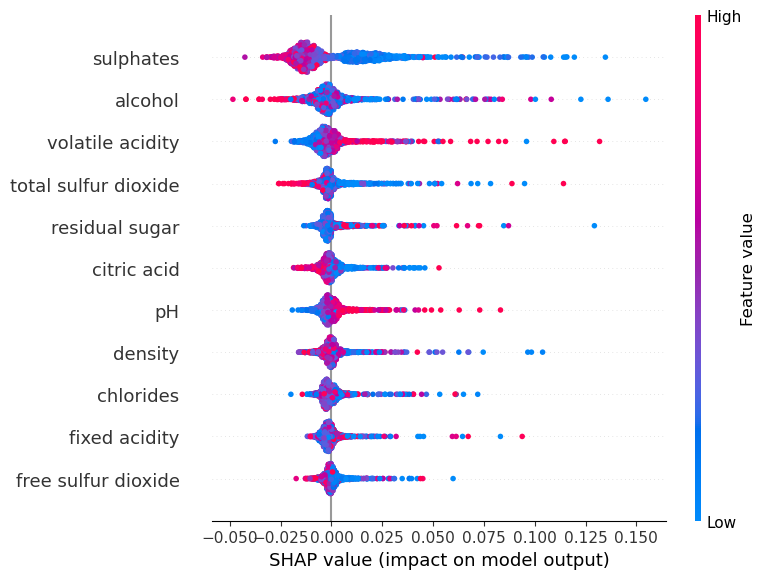

In [44]:
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X)
print(shap_values)
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)
#The x-axis stands for the average of the SHAP value of each feature.

In [26]:
#Explaining specific instance 
# Select a specific instance from the dataset
instance_to_explain = X.iloc[0]

# Compute the SHAP values for the selected instance
shap_values = explainer.shap_values(instance_to_explain)

# Print the SHAP values
print(shap_values)

# Plot the SHAP values for the selected instance
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], instance_to_explain)


[array([-1.33043373e-03,  1.15931085e-03,  7.13800724e-05, -5.05431276e-04,
       -2.44279155e-03,  9.74487793e-05, -4.15124790e-04, -1.68442459e-03,
        8.51559790e-04,  2.73273274e-03, -1.29746904e-03]), array([-0.00447071,  0.00065663,  0.00442245, -0.00233256, -0.00305998,
        0.00050323, -0.00147117, -0.00023682,  0.00055137,  0.00996067,
       -0.01518206]), array([ 0.01696862,  0.06536982,  0.00747623,  0.00651048,  0.00995535,
        0.00909862, -0.00853338,  0.05346719,  0.00695564,  0.0809333 ,
        0.17651064]), array([-0.00865576, -0.05037166, -0.00459977,  0.00236195, -0.0018872 ,
       -0.01265399,  0.01116503, -0.03871037, -0.00418309, -0.0672118 ,
       -0.11020259]), array([-0.00241424, -0.01601061, -0.00585464, -0.00613935, -0.00277757,
        0.00313093, -0.00077441, -0.01225979, -0.00356865, -0.02332055,
       -0.04618017]), array([-9.74839638e-05, -8.03481363e-04, -1.51564241e-03,  1.04912335e-04,
        2.12190801e-04, -1.76234074e-04,  2.906393